# End to end graph generation demo (CORA)

## Overview

In this notebook, we walk through the complete process of generating a synthetic dataset based on a CORA dataset. 

The CORA dataset consists of scientific publications classified into one of seven classes. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary, so we can interpret the CORA dataset as a graph with categorical node features.

Content:

1. [Fit synthesizer](#1)
1. [Dataset generation](#2)
1. [Tabular data evaluation](#3)
1. [Structure evaluation](#4)

### Imports

In [1]:
# preprocessing
from syngen.preprocessing.datasets.cora import CORAPreprocessing

# generation
from syngen.synthesizer.static_graph_synthesizer import StaticGraphSynthesizer
from syngen.generator.tabular.kde_generator import KDEGenerator
from syngen.generator.tabular.uniform_generator import UniformGenerator
from syngen.generator.tabular.gaussian_generator import GaussianGenerator
from syngen.graph_aligner.random_aligner import RandomAligner
from syngen.generator.graph import RMATGenerator

# evaluation
from syngen.analyzer.tabular import TabularMetrics
from syngen.analyzer.graph import Graph
from syngen.analyzer.graph.stats import get_dd_simmilarity_score
from syngen.analyzer.graph.analyser import AnalysisModule

# utils
import cudf
import numpy as np
import pandas as pd  
from syngen.utils.types import MetaData

<a id="1"></a>
### Fit synthesizer

#### Instantiating the building blocks

As the CORA dataset is a graph with node features the following objects are instantiated:

- A node feature generator to generate the node features. In this example we simply choose the Kernel Density Estimate (KDE) generator
- A graph generator to generate the graph structure, e.g. RMAT
- An aligner to align the two, in this case random aligner, to randomly assign the node features to the generated nodes.


**Note**: Alternative generators can be used as long as they implement the `fit` \& `generate` API and consumes data dictionary (described below).

In [2]:
node_feature_generator = KDEGenerator()
static_graph_generator = RMATGenerator()
preprocessing = CORAPreprocessing(cached=False)
graph_aligner = RandomAligner()

#### Defining the synthesizer

Once the set of building blocks are instantiated with the corresponding hyperparameters, we can instantiate a synthesizer which defines how these building blocks interact. 

The static graph synthesizer object, can be used to generate graphs with either node or edge features.

In [3]:
synthesizer = StaticGraphSynthesizer(
                                    graph_generator=static_graph_generator,
                                    graph_info=preprocessing.graph_info,
                                    node_feature_generator=node_feature_generator,
                                    graph_aligner=graph_aligner)

#### Preprocessing

For the CORA dataset a preprocessing step is pre-implemented (see `/syngen/preprocessing/cora.py`), which reads the corresponding data files to create the CORA graph with labels converted into ordinal values.

In [4]:
data = preprocessing.transform('/workspace/data/cora')

The output of the preprocessing function is a dictionary with

- MetaData.EDGE_DATA: data corresponding with the graphs edge information
- MetaData.NODE_DATA: data corresponding with graphs node information.

Now that we have the data, the synthesizer can be fit. This step simply fits each component on the data.

In [5]:
synthesizer.fit(edge_data = data[MetaData.EDGE_DATA], node_data=data[MetaData.NODE_DATA])

<a id="2"></a>
## Dataset Generation

Now that we have a synthesizer fitted on a downstream dataset, we can generate a graph with similar characteristics as the original.

In this example, we simply generate graph of the same size.

In [6]:
num_edges = 5428
num_nodes = 2708 

By calling generate with the desired graph size, it will return a dictionary with keys corresponding to edge data and node data (if the synthesizer was configured to generate these).

In [7]:
data_proper = synthesizer.generate(num_nodes, num_edges, graph_noise=0.5)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.87it/s]


<a id="3"></a>
## Tabular Data Evaluation

Now that we have generated the data we may be interested in assessing the quality of the generated graph.

The tool provides a set of analyzers which can be used to analyze
- tabular features
- graph structure
- both

Below a series of examples are shown comparing the original node feature distribution with various node feature generators

In [8]:
# - extract the fitted node generator from the synthesizer
tabular_generator = synthesizer.node_feature_generator
cols_to_drop = set(['id'])

**Note**: the `id` column is dropped as this simply corresponds to the node id

In [9]:
# - extract node features associated with nodes in the graph
real = data[MetaData.NODE_DATA]
real = real.drop(columns=cols_to_drop).reset_index(drop=True)

In [10]:
# - generate node using the generator used in the synthesizer
# note the synthetic data could be also be replaced with node data
# generated above.
synthetic = tabular_generator.sample(len(real))
synthetic = synthetic.drop(columns=cols_to_drop).reset_index(drop=True)

The `real` and `synthetic` data to be compared are then fed to the `TabularMetrics` object, which can be used to visually compare the data, or provide a series of metrics comparing feature distributions and their correlations.

In [11]:
cat_cols = set(preprocessing.graph_info[MetaData.NODE_DATA]['categorical_columns']) - cols_to_drop

tab_eval = TabularMetrics(real, 
                          synthetic, 
                          categorical_columns=cat_cols)

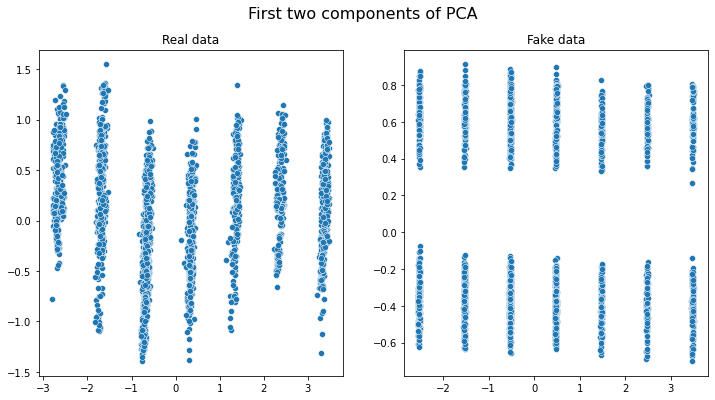

In [12]:
tab_eval.plot_pca()

### Random Tabular Data

In the cell below a comparison is done using a uniform random generator.

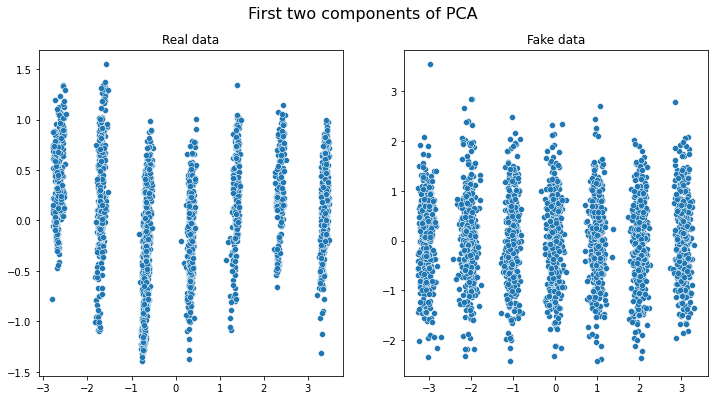

In [13]:
uniform_generator = UniformGenerator()

uniform_generator.fit(real, categorical_columns=cat_cols)

synthetic = uniform_generator.sample(len(real))

tab_eval = TabularMetrics(real, 
                          synthetic, 
                          categorical_columns=cat_cols)

tab_eval.plot_pca()

### Random Multivariate

In the cell below a comparison is done using a multivariate random generator. Note thesimilarity of this with `KDEGenerator` as the KDE generator simply adds gaussian noise and clamps the values.

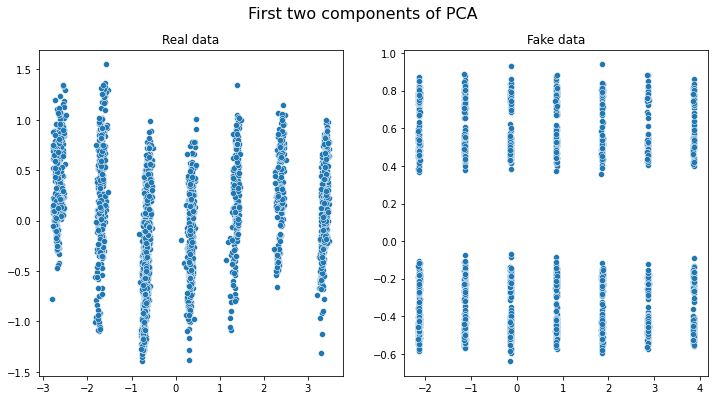

In [14]:
gaussian_generator = GaussianGenerator()

gaussian_generator.fit(real, categorical_columns=cat_cols)

synthetic = gaussian_generator.sample(len(real))

tab_eval = TabularMetrics(real, 
                          synthetic, 
                          categorical_columns=cat_cols)

tab_eval.plot_pca()

<a id="4"></a>
## Structure evaluation

Next the graph structure can similarly be analyzed.

In the following cells the properly generated graph (using the synthesizer), a random graph, as well as the original are compared.

The tool implements a graph analyzer, i.e. `AnalysisModule`, which provides a series of useful metrics to compare graphs across.

First purely the graph structure is extracted, i.e. nodes and edges.

In [15]:
# - generate a random graph
static_graph_generator._fit_results = (0.25, 0.25, 0.25, 0.25)
data_random = static_graph_generator.generate(num_nodes, num_edges, is_directed=False, has_self_loop=False, noise=0.0)
data_random = list(zip(data_random[:, 0], data_random[:, 1]))

In [16]:
# - extract structure from tabular data
data_proper = data_proper[MetaData.EDGE_DATA]
table_df = data[MetaData.EDGE_DATA]
src_name = preprocessing.graph_info[MetaData.EDGE_DATA][MetaData.SRC_NAME]
dst_name = preprocessing.graph_info[MetaData.EDGE_DATA][MetaData.DST_NAME]
src_ids = table_df[src_name]
dst_ids = table_df[dst_name]
src_dst = list(zip(src_ids, dst_ids))
dst_src = list(zip(dst_ids, src_ids))
graph = list(set(src_dst + dst_src))

In [17]:
# - print graph size
print(f'src_dst:{len(src_dst)}')
print(f'dst_srct:{len(dst_src)}')
print(f'graph:{len(graph)}')

src_dst:5428
dst_srct:5428
graph:10842


In [18]:
graph_structure_proper = data_proper[[src_name,dst_name]].to_numpy()
graph_structure_random = data_random
graph_structure_orig = graph

In [19]:
# - save graph structure to file
np.savetxt('/workspace/data/cora_demo_proper.txt', np.array(graph_structure_proper), fmt='%i', delimiter='\t')
np.savetxt('/workspace/data/cora_demo_random.txt', np.array(graph_structure_random), fmt='%i', delimiter='\t')
np.savetxt('/workspace/data/cora_demo_orig.txt', np.array(graph_structure_orig), fmt='%i', delimiter='\t')

In [20]:
# - instantiate graph analyzer
graph_analyser = AnalysisModule()

Graph objects are then instantiated using the extracted graph structures

In [21]:
proper_graph = Graph('/workspace/data/cora_demo_proper.txt', name='properly_generated', load_eagerly=True, is_directed=False)
random_graph = Graph('/workspace/data/cora_demo_random.txt', name='randomly_generated', load_eagerly=True, is_directed=False)
orig_graph = Graph('/workspace/data/cora_demo_orig.txt', name='original', load_eagerly=True, is_directed=False)
all_graphs = [proper_graph, random_graph, orig_graph]

The graphs can then be fed to various metrics, for example `get_dd_similarity_score` provides a score between 0 and 1,
comparing the degree distribution of a source graph and destination graph.

In [22]:
orig_proper = get_dd_simmilarity_score(graph_structure_orig, graph_structure_proper, cdf_points=1000)
orig_random = get_dd_simmilarity_score(graph_structure_orig, graph_structure_random, cdf_points=1000)

print("DEGREE SIMILLARITY SCORE")
print("ORIG vs PROPER:", orig_proper)
print("ORIG vs RANDOM:", orig_random)

DEGREE SIMILLARITY SCORE
ORIG vs PROPER: 0.5960266229903345
ORIG vs RANDOM: 0.517048910571943


The `compare_graph_stats` compares the graphs across a series of statistics

In [23]:
df = graph_analyser.compare_graph_stats(*all_graphs)
df

,Category,Statistic,properly_generated,randomly_generated,original
0,Global stats,Nodes,3576,3748,2222
1,Global stats,Edges,5428,5428,5423
2,Global stats,Density,0.0008,0.0008,0.0022
3,Global stats,Average degree,1.52,1.45,2.44
4,Global stats,Zero deg nodes,0,0,0
5,Global stats,Zero in deg nodes,0,0,0
6,Global stats,Zero out deg nodes,0,0,0
7,Global stats,Self loops,0,0,4
8,Global stats,Bidirectional edges,5428,5428,5419
9,Global stats,Unique undirected edges,5428,5428,5419


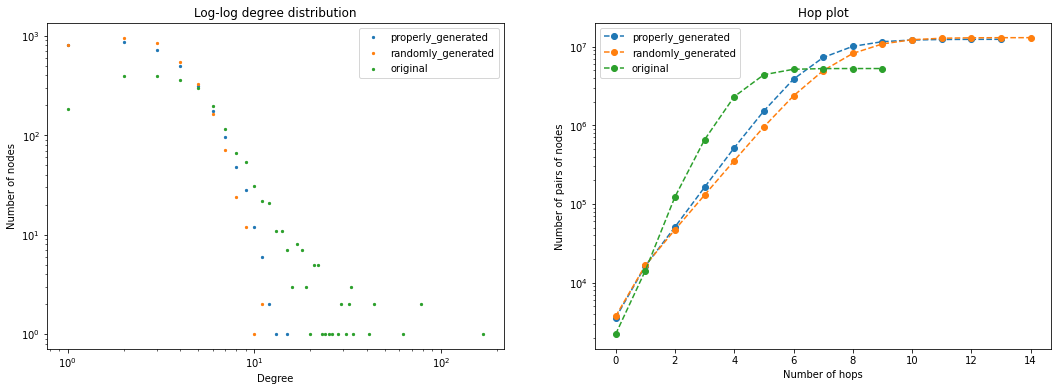

In [24]:
from matplotlib.pyplot import set_loglevel
set_loglevel('warning')
_ = graph_analyser.compare_graph_plots(*all_graphs);